# Phase Transitions in Model 2D Ferromagnet with Effective Interactions
## By DW Tola (May 2024)
# Appendix [A1](#http://arxiv.org/abs/2403.06162:2403.06162) Supplementary Notebook

## Model B  (Model A is also included for Comparison)

In [1]:
import numpy as np
from numpy.random import rand
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

* This python based jupyter-notebook demonstrates simple example that support the findings of the study [report](#http://arxiv.org/abs/2403.06162:2403.06162) "Nonequilibrium phase transitions in a 2D Ferromagnetic spins with effective interactions". Currently, the paper has been submitted to IOP Publishing (JPA). Notice that we use this notebook for demonstration purpose. Most of the main results in the [report](#http://arxiv.org/abs/2403.06162:2403.06162) were calculated using c++ on HP Z2 [workstaion](img/hardware).
![hardware](img/hardware.png)

## 1)   Metropolis Monte Carlo Dynamics (MMCD)
 * In the [report](#http://arxiv.org/abs/2403.06162:2403.06162) the most commonly used transition rates namely the Metropolis update rule is defined as
$$
W =  \underbrace{\texttt{MIN} \left[1, \exp\left[ -\beta  \Delta E \right]\frac{}{}\right]}_{\rm (A13)}
 \;  \Rightarrow   \; \underbrace{\texttt{MIN} \left[1, \exp\left[-\beta  d E \right]\frac{}{}\right]}_{\rm (B13)} \texttt{,}
$$
where $\beta = 1/T$ and $ \Delta E $ is the energy change due to the transition from a present state to a new one. 
* It has been shown that this change in energy is given as
$$
 \Delta E =   (1+ h) dE^{0}  \texttt{,}
$$
where $h$ is an effective parameter and $ d E^{0} = \Delta E (h=0)$ is well-known.
* The arrow declares that an update rule is modified through replacing $\Delta E$ by $dE$, where
$$
d E =  \Delta E^{0} +  h |\Delta E^{0}|\rm{, \; \; \; \;  \; \; }   \Delta E^{0} =  2 S_{i} \sum_j S_{j} \texttt{.}
$$
Therefore, replacing $\Delta E$ in (A13) by this effective $d E$, we get the modified update rule (B13).
The [flow chart](img/figure01.PNG) summarizes the modified Metropolis algorithm which was one of the update rule implemented.
![flow chart](img/figure01.PNG)
* The basics of the flow chart are as follows. Suggest a transition from $S_{i}=\pm 1$ to $S_{i}=\mp  1$ and always accept accept the transition with a certain probability which requires to compute ratio $r=fp$. Then generate a random number $u=rand()$ distributed uniformly between $0 \leq u < 1$ and accept the transition if $\ln u < \ln fp$. If $\ln fp>0$,  it is actually unnecessary to bother generating $u$.
For the main [results](#http://arxiv.org/abs/2403.06162:2403.06162), this process would be repeated for $N$ sweeps as a MC step (MCS) per site where we discard the first $10^{5}$ MCS per site to allow it to attain NESS for all systems. Then again, we measure the averaged quantities of interest in completing more $10^{5}$ MCS per site. The average over the representatives is done using 100 independent measurements. However, these all should be reduced here for simplicity.


In [2]:
def randomstate(L):
    '''
    Returns a random state of Ising configuration to ascertain an initial condition
    '''
    state = np.random.choice([-1,1], size=(L,L))
    return state

<function matplotlib.pyplot.show(close=None, block=None)>

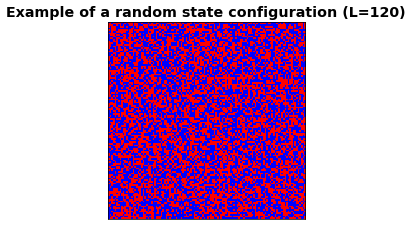

In [3]:
random_confg=randomstate(120)
fig,ax=plt.subplots(figsize=(4,4),dpi=64)
ax.matshow(random_confg, cmap=plt.cm.bwr)
ax.set_xticks([]),ax.set_yticks([])
plt.title("Example of a random state configuration (L=120)", fontsize = 16,fontweight="bold")
plt.show

* Let $\Delta E^{0} =\texttt{dE0}$,
$$\texttt{dE0} = 2 S_{i} \sum_j S_{j} \equiv \{-8,-4,0,4,8\},$$
is the change in the energy if the flip is accepted for the usual Metropolis update rule, the modified versions are

###  Model A: 
The version that satisfies DB is 
$$\texttt{ dEA = dE0*(1+h)}$$

###  Model B: 
Calculate values of the quantities in which the update rule uses
 $$\texttt{ dEB = dE0+h*abs(dE0)},$$
where we define $h$ as an effective  parameter $\texttt{h=heff}$ that takes any fixed value  $-1\le h < \infty $.

## Note: 
Given $f = \texttt{min(1, np.exp(-beta*dE))}$ then
$$
\ln f = \texttt{min(0, -beta*dE)}$$


### Block of functions used in the $ \texttt{Main}$ part

In [4]:
def mmcd(confg, beta,arg):
    '''
    Metropolis MC Dynamics
    confg = Configuration of 2D Ising state
    beta = 1./T
    arg = True: Model A with DB (A13)
    arg = False: Model B without DB (B13) '''  
    for ix in range(L):
        for iy in range(L):
            x = np.random.randint(0, L)
            y = np.random.randint(0, L)
            si =  confg[x, y]
            sjn = confg[(x+1)%L,y]+confg[x,(y+1)%L]+confg[(x-1)%L,y]+confg[x,(y-1)%L] 
            dE0 = 2.*si*sjn
            dEA = dE0*(1+h)
            dEB = dE0+h*abs(dE0)
            '''
            f = Flipping probability 
            lnfA = min(0, -beta*dEA)  for Model A
            lnfB = min(0, -beta*dEB)  for Model B '''
            if arg==False and np.log(rand())<min(0,-beta*dEB):
                si *= -1
            if arg==True and np.log(rand())< min(0,-beta*dEA):
                si *= -1
            confg[x, y] = si
    return confg
def EvEnergy(confg,arg):
    '''
    Evaluate an energy of the confg
    '''
    energy=0.
    for i in range(len(confg)):
        for j in range(len(confg)):
            Si = confg[i,j]
            Sjn = confg[(i+1)%L,j]+confg[i,(j+1)%L]+confg[(i-1)%L,j]+confg[i,(j-1)%L]
            energy -= Si*Sjn*(1.0+h)
    return 0.5*energy      # 0.5 compensates the double counting
def EvMagnetization(confg):
    '''
    Evaluate Magnetization of the confg
    '''
    magnetization = np.sum(confg)
    return np.abs(magnetization)

### Input Parameters

In [5]:
'''
Effective Parameter: {-1<h<1} but we can use any h>-1 as well.
Try to switch between different values of h and see how it works.
Example: h = {-0.8, -0.5, -0.25, 0.25,0.5, 1,1.5, ...}'''
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
h = 0.25
'''
'Default Ep = \pm 0.25 '''
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
if h>=0:
    Thi = 4*(1+h);     # The starting high (hot) temperature
    Tlo = 1.*(1+h);     # The low (cold) temperature
else:Thi = 3.2; Tlo =-0.2
nt = int(51)      # number of temperature
T  =  np.linspace(Thi, Tlo,nt);
TcO = 2/np.log(1.0+np.sqrt(2))      # Tc for h = 0 is known
if h>=1:
    Tch=2*TcO
    Tc= (1+h)*TcO                   # Tc for mod C
elif h<1 and h>-1: 
    Tch = (1+h)*TcO                 # Tc for db = False
    Tc= (1+h)*TcO 
else:
    Tch = 0; 
    Tc= (abs(h)-1)*TcO   

In [6]:
Thi,Tlo,nt,Tc,Tch,h

(5.0, 1.25, 51, 2.8364816427662776, 2.8364816427662776, 0.25)

In [7]:
'''
For fast simulation, please change the following  parameters each to its minimal value 
'''
L  = 20              #  size of the lattice, N = L x L
eqMCS = 3200         #  number of MCS for equilibration
evMCS = 3200         #  number of MCS for evaluation or measurement
N = int(L*L)
n1 = 1.0/(evMCS*N)
n2  =  1.0/(evMCS*evMCS*N)
m,E = np.zeros(nt),np.zeros(nt)
X,C =  np.zeros(nt),np.zeros(nt)

### The $ \texttt{Main}$ part 

In [8]:
def main(arg):
    for t in range(nt):
        '''
        initialize'''
        confg = randomstate(L)
        M1=E1 = 0
        M2=E2 = 0
        ib=1./T[t]; ib2=ib*ib;

        for i in range(eqMCS):           # equilibrate
            mmcd(confg,ib,arg)           # Metropolis MC Dynamics

        for i in range(evMCS):
            mmcd(confg,ib,arg)       
            En = EvEnergy(confg,arg)       # evaluate the energy
            Mn  = EvMagnetization(confg)  # evaluate the magnetisation
            E1 = E1 + En
            M1 = M1 + Mn
            M2 = M2 + Mn*Mn
            E2 = E2 + En*En
        '''
        obtain intensive values ''' 
        m[t] = n1*M1
        E[t] = n1*E1
        X[t] = (n1*M2 - n2*M1*M1)*ib
        C[t] = (n1*E2 - n2*E1*E1)*ib2
    return arg

In [9]:
'''
arg = True  for Model A
The DB is valid
'''
main(True)

True

 ###  Calculated values of the quantities in which the update rule uses fixed value of  $$h=\{-1<\texttt{h}< 1\}$$.

In [10]:
'''
Data frame (df) refers to the results calculated in which DB = True for model B with DB. That is model A
For h=0, the well-known results can be retrieved.
'''
dfA = pd.DataFrame({'T':T,'m':m, 'X': X, 'E':E, 'C': C})
dfA.head()

,T,m,X,E,C
0,5.000,0.081753,0.314323,-0.695063,0.175685
1,4.925,0.086425,0.347706,-0.708512,0.177874
2,4.850,0.084766,0.341711,-0.726652,0.184273
3,4.775,0.087016,0.357577,-0.740953,0.203357
4,4.700,0.085538,0.346076,-0.746152,0.204967


 ###  Calculated values of the quantities in which the update rule uses $\texttt{heff}=\texttt{Ep/dE0}$ for fixed $\texttt{Ep}$.

In [11]:
'''
arg = False
Model B is without DB
'''
main(False)

False

In [12]:
dfB = pd.DataFrame({'T':T,'m':m, 'X': X, 'E':E, 'C': C})

### Plot the calculated values of the quantities

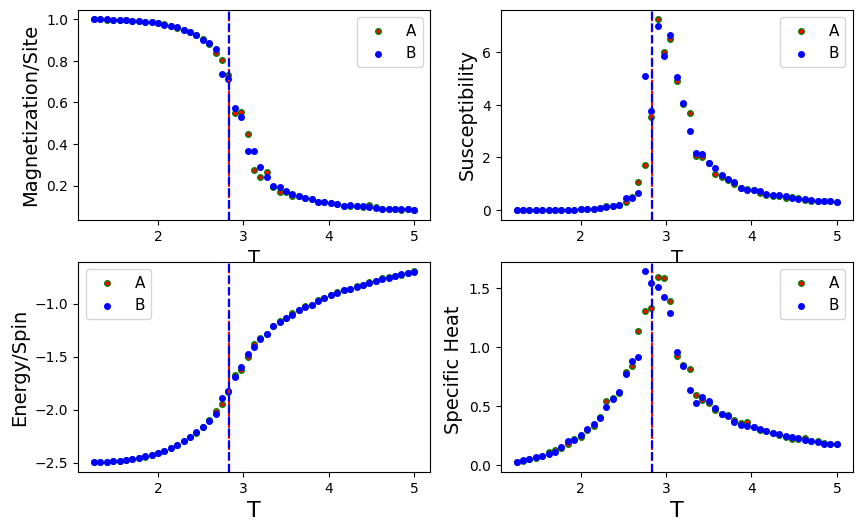

In [13]:
'''
Plot of the calculated quantities (here h = 0.25) for L = 20 
'''
dot = int(16)
x=T
f = plt.figure(figsize=(10, 6));
sf = f.add_subplot(2,2,1);
sf.scatter(x, dfA["m"], s=dot, marker='o', color='g',label="A",fc="r");
plt.axvline(Tc, c='r', ls ='--', lw='1.5');
sf.scatter(x, m, s=dot, marker='o', color='b', label = "B");
plt.axvline(Tch, c='b', ls ='--', lw='1.6');
plt.xlabel("T", fontsize=14); 
plt.ylabel("Magnetization/Site", fontsize=14); plt.axis('tight');
plt.legend(fontsize=11)
sf = f.add_subplot(2,2,2);
sf.scatter(x, dfA["X"], s=dot, marker='o', color='g',label = "A",fc="r");
plt.axvline(Tc, c='r', ls ='--', lw='1.5');
sf.scatter(x, X, s=dot, marker='o', color='b', label = "B");
plt.axvline(Tch, c='b', ls ='--', lw='1.6');
plt.xlabel("T", fontsize=14); 
plt.ylabel("Susceptibility", fontsize=14);   plt.axis('tight');
plt.legend(fontsize=11)
sf = f.add_subplot(2,2,3);
sf.scatter(x,dfA["E"], s=dot, marker='o', color='g',label = "A",fc="r");
plt.axvline(Tc, c='r', ls ='--', lw='1.5');
sf.scatter(x, E, s=dot, marker='o', color='b', label = "B");
plt.axvline(Tch, c='b', ls ='--', lw='1.6');
plt.xlabel("T", fontsize=16);
plt.ylabel("Energy/Spin", fontsize=14); plt.axis('tight');
plt.legend(fontsize=11)
sf=f.add_subplot(2,2,4);
sf.scatter(x, dfA["C"],s=dot, marker='o', color='g',label = "A",fc="r");
plt.axvline(Tc, c='r', ls ='--', lw='1.5');
sf.scatter(x, C, s=dot, marker='o', color='b', label = "B");
plt.axvline(Tch, c='b', ls ='--', lw='1.6');
plt.xlabel("T", fontsize=16);  
plt.ylabel("Specific Heat ", fontsize=14);   plt.axis('tight');
plt.legend(fontsize=11)
plt.show()

### Figure:
* Plots of physical quantities magnetization per site, magnetic susceptibility, energy per spin and specific heat all as a function of temperature $T$. For values of $\texttt{h}\ge-1$ the position of vertical dashed lines (red and blue colors) provide estimate of $T_{c}$ in each of the two Models A and B (see keys).

* The examples $\texttt{h=-0.25}$ shows that the results are agree with each other.

## 2) Glauber Monte Carlo Dynamics (GMCD)
See the second notebook gmcd.